Recordatorio: si se est√° trabajando en un contenedor recien instalado, va a ser necesario instalar git-hub todas las librerias requeridas

## Alumno: Alex Barria

## Vision Transformer (ViT)

El **Vision Transformer (ViT)** es un modelo innovador para la clasificaci√≥n de im√°genes que transforma las im√°genes en secuencias de parches m√°s peque√±os, com√∫nmente de $16 \times 16$ p√≠xeles, como se describe en el paper de [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy)  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Cada parche se considera como una "palabra" o "token" y se proyecta en un espacio de caracter√≠sticas. Mediante la incorporaci√≥n de cifrados de posici√≥n y un token de clasificaci√≥n, podemos aplicar un Transformer de manera convencional a esta secuencia, permitiendo su entrenamiento para tareas de clasificaci√≥n de im√°genes.

## Embeddings y Cifrado de Posici√≥n

### Embeddings
En el contexto de ViTs, las im√°genes son primero divididas en peque√±os bloques o patches (como si se cortaran en peque√±os cuadrados). Estos patches se tratan como si fueran palabras en un modelo de lenguaje, y a cada uno se le asigna un embedding. Un embedding es simplemente una representaci√≥n num√©rica del patch en un espacio de alta dimensi√≥n que captura caracter√≠sticas relevantes del mismo.

Por ejemplo, si divides una imagen de 224x224 p√≠xeles en 16x16 bloques, tendr√°s 196 patches en total. Cada uno de esos patches se convierte en un vector de embedding, que luego se alimenta al modelo Transformer.

### Positional Embedding (Cifrado Posicional):

El **embedding posicional** agrega informaci√≥n sobre la ubicaci√≥n de cada parche en la imagen original. En el paper de Alexey Dosovitskiy et al., se evaluaron varias formas de codificar la informaci√≥n espacial con embebidos posicionales. Se observ√≥ que, aunque el uso de embebidos mejora el rendimiento en comparaci√≥n con no usarlos, no hay diferencias significativas entre los m√©todos probados. Se concluy√≥ que, dado que el modelo opera a nivel de parches en lugar de p√≠xeles, la forma espec√≠fica de codificar la posici√≥n es menos relevante.
## Proceso de Creaci√≥n de Embeddings

1. **Divisi√≥n en Parches**: La imagen se divide en parches de $N \times N$ p√≠xeles.
   
2. **Generaci√≥n de Embeddings**: Cada parche se transforma en un embedding que captura su informaci√≥n relevante.

3. **Cifrado de Posici√≥n**: Se a√±ade un vector de cifrado de posici√≥n a cada embedding. 

   Algunos ejemplos del cifrado:


   *  **Codificaci√≥n Sinusoidal:** La f√≥rmula sinusoidal para embebidos posicionales (tradicional en Transformers-NLP) genera los valores de los embebidos en funci√≥n de senos y cosenos. Estos valores dependen directamente de la posici√≥n y siguen una periodicidad espec√≠fica para capturar relaciones posicionales. Es determinista y no se ajusta durante el entrenamiento, ya que los valores est√°n calculados y fijos para cada posici√≥n.
   Donde:
       - $pos$ es la posici√≥n en la secuencia.
       - $i$ es el √≠ndice de la dimensi√≥n.
       - $d_{model}$ es la dimensi√≥n del modelo.

   $$PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$

   $$PE(pos, 2i + 1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)$$



   * **Embebido Posicional Aprendido (a ser implementada por el alumno):** los embebidos posicionales se definen como un par√°metro de la red neuronal (usando [nn.Parameter](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)), lo que significa que los valores para el embebido  posicional se aprenden durante el proceso de entrenamiento. Se define embedding, matriz de tama√±o (1, num_patches, embed_dim), donde num_patches es el n√∫mero de parches (posiciones) en la secuencia de la imagen y  embed_dim es la dimensi√≥n de los embebidos. La inicializaci√≥n torch.randn genera valores aleatorios para estos embebidos posicionales, y luego el modelo los optimiza durante el entrenamiento, ajustando los valores en funci√≥n de los gradientes.

4. **Combinaci√≥n de Embeddings y Cifrado de Posici√≥n**: Se suma cada embedding con su correspondiente cifrado de posici√≥n, generando un vector final que contiene tanto la informaci√≥n del contenido del parche como su posici√≥n en la imagen.

El resultado es una serie de vectores, cada uno representando un parche y su posici√≥n, que se alimentan a las capas del Transformer. Esto permite al modelo aprender no solo sobre las caracter√≠sticas individuales de cada parche, sino tambi√©n sobre c√≥mo estos se relacionan entre s√≠ en el contexto de la imagen completa.


![Vision Transformer](vit.gif)

*Cr√©dito: [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)*


A continuaci√≥n, trabajaremos con los **patch embeddings** y la **codificaci√≥n posicional**, esenciales para que el modelo pueda interpretar las relaciones espaciales en las im√°genes. 

## Tareas:

1. **Modificar los parametros:** Cambiar el tama√±o de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener m√°s o menos parches/dimensiones.

2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificaci√≥n sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 


Dispositivo utilizado: mps


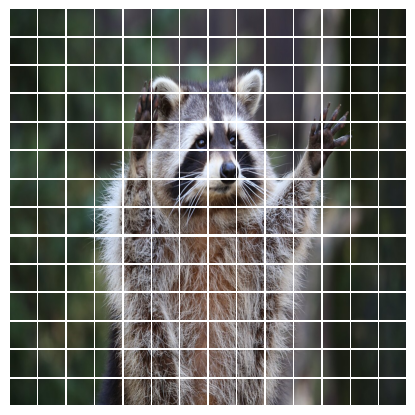

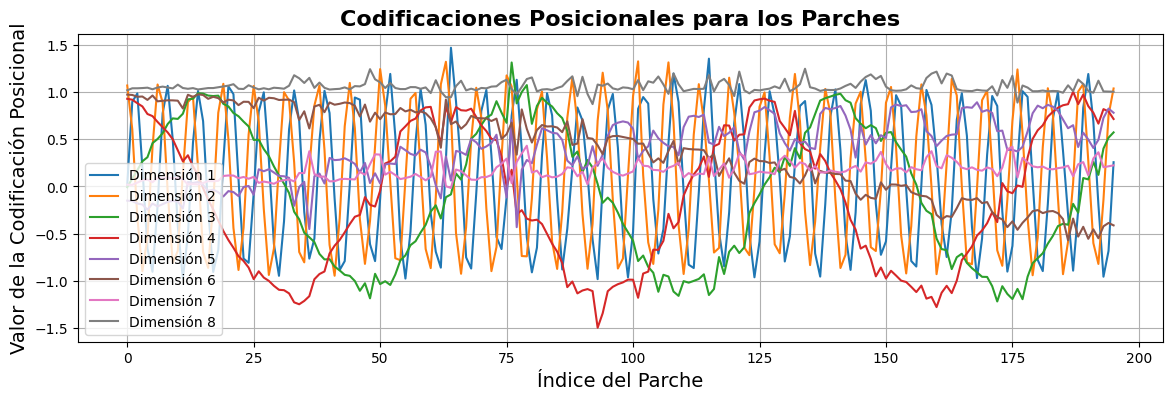

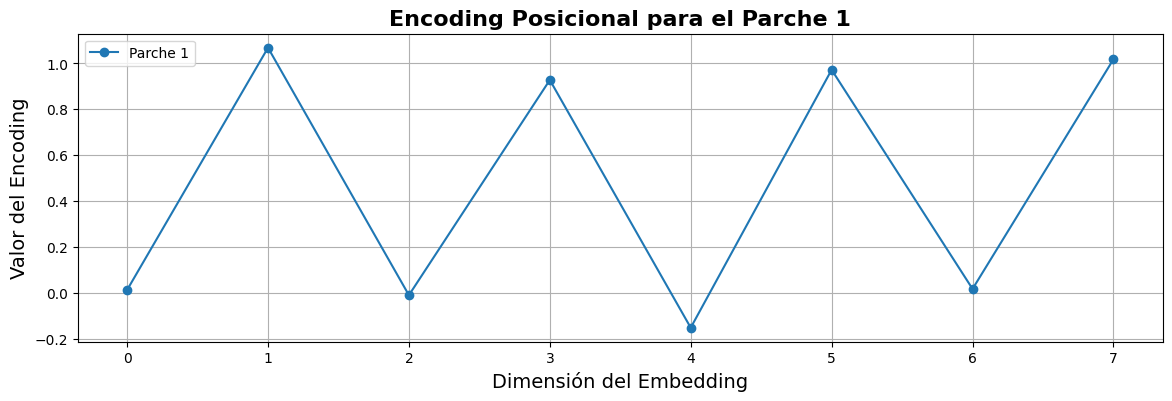

In [15]:
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

# La configuraci√≥n, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)  # Aplicar seno en dimensiones pares
        pos_encoding[:, 1::2] = torch.cos(position * div_term)  # Aplicar coseno en dimensiones impares
        return pos_encoding.unsqueeze(0)  # A√±adir dimensi√≥n de batch

    def forward(self, x):
        return x + self.pos_embedding

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))  # (1, num_patches, embed_dim)

    def forward(self, x):
        return x + self.pos_embedding

class Visualization:
    @staticmethod  # No requiere self
    def visualize_patches(patches: Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod  # No requiere self
    def visualize_positional_encoding(pos_embeddings: Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dimensi√≥n {i + 1}')
        plt.xlabel('√çndice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificaci√≥n Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: Tensor, patch_idx: int):
        num_patches = pos_embeddings.shape[1]
        if patch_idx < 0 or patch_idx >= num_patches:
            raise ValueError(f"El √≠ndice del parche debe estar entre 0 y {num_patches - 1}, pero se recibi√≥ {patch_idx}.")
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensi√≥n del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()




# Par√°metros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El √≠ndice del parche para el cual queres visualiizar la codificaci√≥n posicional

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracci√≥n de parches y visualizaci√≥n
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generaci√≥n de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificaci√≥n posicional
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)




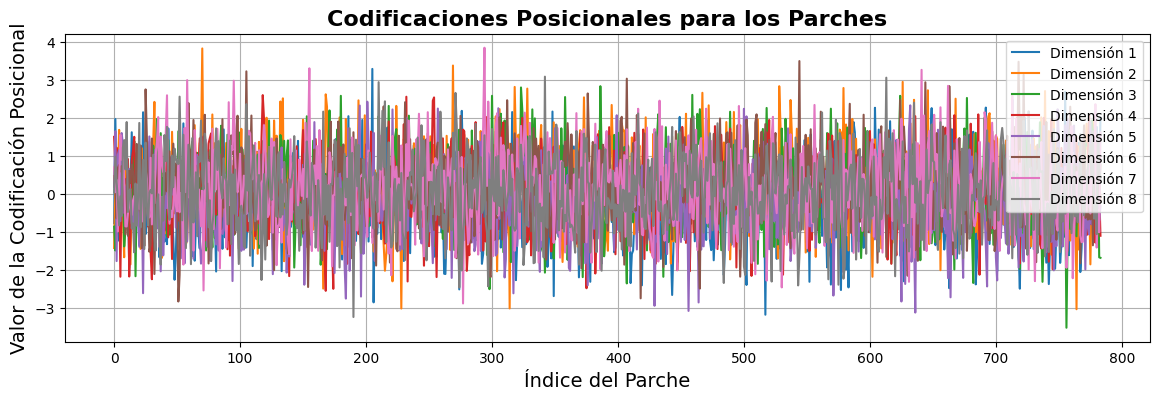

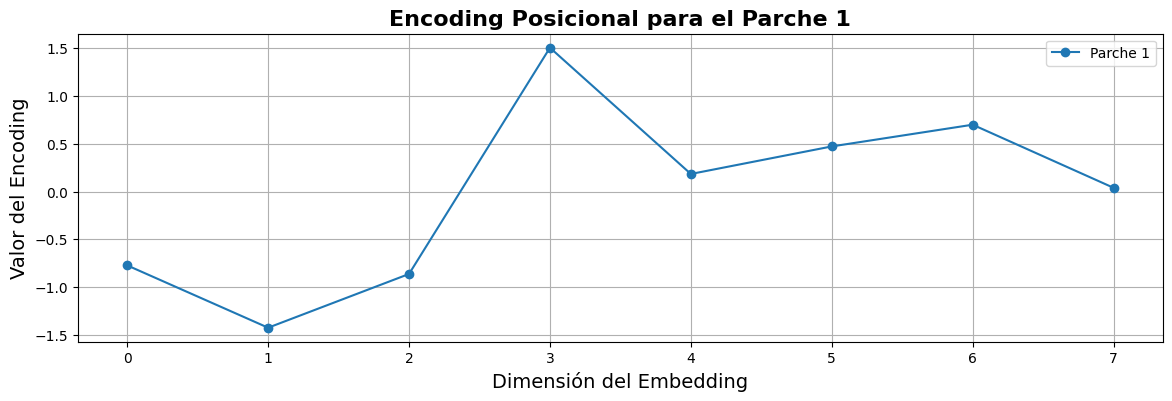

In [5]:
# Codificaci√≥n posicional aprendida
positional_encoding_learned = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
pos_embeddings_learned = positional_encoding_learned(patches)

# Visualizaciones
Visualization.visualize_positional_encoding(pos_embeddings_learned)
Visualization.visualize_single_patch_encoding(pos_embeddings_learned, patch_idx)

## Soluci√≥n
>1. **Modificar los parametros:** Cambiar el tama√±o de los parches, y la cantidad de dimensiones del embedding. Investigar y describir las ventajas y desventajas de tener m√°s o menos parches/dimensiones.

## üîç An√°lisis sobre el Tama√±o de Parche y la Dimensi√≥n del Embedding

En este experimento se evaluaron distintas configuraciones de tama√±o de parche (`patch_size`) y dimensi√≥n del embedding (`embed_dim`). En particular, se analizaron tama√±os de parche de **32**, **64** y **128** p√≠xeles, para estudiar c√≥mo afectan a la granularidad de la representaci√≥n y a la codificaci√≥n posicional.


### üìê Tama√±o del Parche (`patch_size`)

**‚úÖ Ventajas de usar parches m√°s peque√±os (por ejemplo, 32):**
- Mayor **granularidad**: cada parche captura una porci√≥n m√°s peque√±a de la imagen, √∫til para detectar detalles finos.
- Se generan m√°s parches, lo cual permite modelar **relaciones espaciales m√°s precisas**.
- √ötil en tareas que dependen de informaci√≥n local, como detecci√≥n de bordes o texturas.

**‚ö†Ô∏è Desventajas:**
- Aumenta la **longitud de la secuencia** de entrada, lo cual incrementa el **costo computacional**.
- Puede dificultar la integraci√≥n de contexto global si no se entrena adecuadamente.

**‚úÖ Ventajas de usar parches m√°s grandes (por ejemplo, 128):**
- Capturan regiones m√°s amplias de la imagen, facilitando el an√°lisis de **estructura global**.
- Se reduce el n√∫mero total de parches, disminuyendo el **uso de memoria y tiempo de c√≥mputo**.

**‚ö†Ô∏è Desventajas:**
- Se pierde **informaci√≥n local detallada**.
- Menor resoluci√≥n espacial de la imagen original en la representaci√≥n del modelo.

### üñºÔ∏è Ejemplos visuales de divisi√≥n por parches

A continuaci√≥n se muestran ejemplos del mismo input dividido con diferentes tama√±os de parche. Se puede observar c√≥mo var√≠a la granularidad de la representaci√≥n.

#### üìè Tama√±o de parche: 32x32
![Parches 32x32](./Images/patches_32.png)

#### üìè Tama√±o de parche: 64x64
![Parches 64x64](./Images/patches_64.png)

#### üìè Tama√±o de parche: 128x128
![Parches 128x128](./Images/patches_128.png)
- En la figura con `patch_size = 32`, se observa una cuadr√≠cula densa, lo que permite una segmentaci√≥n muy detallada.
- Con `patch_size = 64`, se logra un **equilibrio** entre resoluci√≥n y eficiencia.
- En `patch_size = 128`, la cantidad de parches es baja, lo que reduce la complejidad, pero tambi√©n la riqueza de representaci√≥n.


### üî¢ Dimensi√≥n del Embedding (`embed_dim`)

**‚úÖ Ventajas de mayor dimensi√≥n (por ejemplo, 64 o 128):**
- Mayor **capacidad representacional** para capturar patrones complejos.
- Mejora el poder expresivo del modelo.

**‚ö†Ô∏è Desventajas:**
- M√°s par√°metros ‚Üí mayor riesgo de **overfitting** si no se cuenta con suficientes datos.
- Requiere **m√°s memoria y poder computacional**.

**‚úÖ Ventajas de menor dimensi√≥n (por ejemplo, 8 o 16):**
- Modelo m√°s **ligero** y r√°pido.
- Menor riesgo de sobreajuste en datasets peque√±os.

**‚ö†Ô∏è Desventajas:**
- Capacidad limitada para representar variaciones visuales sutiles.
- Menor poder expresivo.


### ‚úÖ Conclusi√≥n

La elecci√≥n del `patch_size` y `embed_dim` representa un **trade-off entre granularidad, capacidad de representaci√≥n y eficiencia computacional**.

- Para tareas donde los **detalles locales** son clave, conviene usar parches m√°s peque√±os y embeddings de mayor dimensi√≥n.
- Para tareas m√°s globales o cuando se busca **eficiencia**, se puede optar por parches grandes y embeddings m√°s reducidos.

En definitiva, la configuraci√≥n ideal depende del **contexto de la tarea**, los **recursos disponibles** y la **cantidad de datos para entrenar** el modelo.


---


> 2. **Implementar embedding posicional aprendido 1D:** Partiendo de ejemplo proporcionado (codificaci√≥n sinusoidal en clase PositionalEncoding), implementar una clase PositionalEncodingLearned que utilice PyTorch y genere embebidos posicionales aprendidos. Graficar. 

Para resolver este punto, se cre√≥ la clase `PositionalEncodingLearned` que utiliza `nn.Parameter` y `torch.randn` para crear una matriz de valores que se inicializan con valores aleatorios y luego se van actualizando en los sucesivos pasajes fordward durante el entrenamiento del modelo.

La gr√°fica inicial de estos encodings, como es de esperar, muestra patrones aleatorios al comienzo. Como se pueden ver en la siguiente imagen:
![Learned embeddings](./Images/embeddings_learned.png)

### ‚úÖ Conclusi√≥n

La implementaci√≥n de la clase `PositionalEncodingLearned` permiti√≥ incorporar una codificaci√≥n posicional **aprendida** como alternativa a la codificaci√≥n sinusoidal est√°tica. A diferencia de esta √∫ltima, los embeddings posicionales aprendidos se inicializan con valores aleatorios y tienen la capacidad de **adaptarse durante el entrenamiento**, optimiz√°ndose seg√∫n la tarea espec√≠fica.

Esto representa una ventaja potencial frente a las codificaciones fijas, ya que el modelo puede ajustar las representaciones posicionales en funci√≥n de lo que aprende, permitiendo una mayor **flexibilidad y expresividad**. Sin embargo, tambi√©n introduce un mayor riesgo de sobreajuste si no se cuenta con suficiente cantidad de datos o regularizaci√≥n adecuada.

En resumen, los embebidos posicionales aprendidos ofrecen una soluci√≥n m√°s din√°mica que puede mejorar el rendimiento del modelo, aunque requieren entrenamiento para alcanzar su verdadero potencial, ya que en su estado inicial no contienen informaci√≥n estructurada, como se observa en la visualizaci√≥n adjunta.